In [1]:
import torch
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import logging
import os


import pyro
from pyro.optim import Adam
from pyro.infer import SVI, Trace_ELBO, MCMC, NUTS
import pyro.distributions as dist
import pyro.distributions.constraints as constraints


pyro.__version__

'1.8.4'

In [2]:
smoke_test = ('CI' in os.environ)
assert pyro.__version__.startswith('1.8.4')

pyro.enable_validation(True)
pyro.set_rng_seed(1)
logging.basicConfig(format='%(message)s', level=logging.INFO)

# Set matplotlib settings
%matplotlib inline
plt.style.use('default')

In [3]:
DATA_URL = "https://d2hg8soec8ck9v.cloudfront.net/datasets/rugged_data.csv"
data = pd.read_csv(DATA_URL, encoding="ISO-8859-1")
df = data[["cont_africa", "rugged", "rgdppc_2000"]]
df.head()

,cont_africa,rugged,rgdppc_2000
0,0,0.462,NaN
1,0,2.518,NaN
2,1,0.858,1794.729
3,0,0.013,NaN
4,0,3.427,3703.113


In [4]:
df = df[np.isfinite(df.rgdppc_2000)]
df['rgdppc_2000'] = np.log(df['rgdppc_2000'])

In [5]:
train = torch.tensor(df.values, dtype=torch.float)

In [6]:
is_cont_africa, ruggedness, log_gdb = train[:,0], train[:,1], train[:,2]


In [7]:
log_gdb

tensor([ 7.4926,  8.2169,  9.9333,  9.4070,  7.7923,  9.2125, 10.1432, 10.2746,
         7.8520,  6.4324, 10.2148,  6.8661,  6.9062,  7.2992,  8.6960,  9.6758,
         9.7396,  8.5745,  8.4768,  8.6775,  7.7827,  8.8957,  9.6350,  8.9493,
         7.0458, 10.2142, 10.3143,  9.1177,  8.2760,  7.3624,  7.5405,  6.5053,
         6.8642,  8.7393,  7.4789,  8.4886,  9.0620,  9.9193,  9.6404, 10.1457,
         7.5401,  8.6881, 10.2664,  8.7657,  8.5975,  8.1237,  8.1882,  6.8155,
         9.9881,  9.1863,  6.4549, 10.1485,  8.5071, 10.1542,  8.7191, 10.1785,
         7.5393,  7.5458,  7.5887,  7.4548,  6.6625,  9.6284,  9.7638,  8.9275,
         8.2876,  8.3119, 10.1580,  7.8265,  9.1638,  7.4947,  9.4898,  8.0157,
         7.7895, 10.3265,  8.6702, 10.2726, 10.0799, 10.1264,  8.2026,  8.2550,
        10.1743,  8.4326,  6.9263,  7.3524,  7.5278,  9.3259,  9.6911,  9.6778,
         7.3588,  8.3467,  8.6342,  8.1958,  7.6604,  9.0788, 10.9646,  8.9751,
         9.8299,  8.1645,  7.1940,  6.71

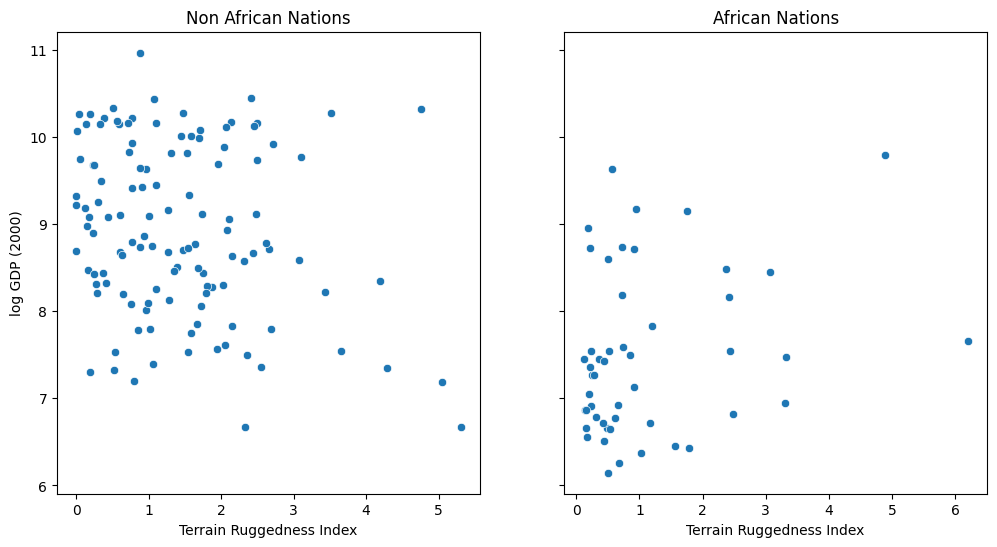

In [8]:
# possible relationship between ruggedness and GDP

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 6), sharey=True)
african_nations = df[df["cont_africa"] == 1]
non_african_nations = df[df["cont_africa"] == 0]
sns.scatterplot(x=non_african_nations["rugged"],
                y=non_african_nations["rgdppc_2000"],
                ax=ax[0])
ax[0].set(xlabel="Terrain Ruggedness Index",
          ylabel="log GDP (2000)",
          title="Non African Nations")
sns.scatterplot(x=african_nations["rugged"],
                y=african_nations["rgdppc_2000"],
                ax=ax[1])
ax[1].set(xlabel="Terrain Ruggedness Index",
          ylabel="log GDP (2000)",
          title="African Nations");

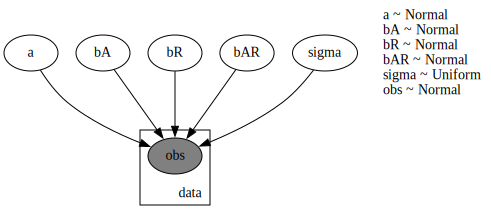

In [9]:
# linear regression predictor
# mean = a + b_a * is_cont_africa + b_r * ruggedness + b_ar *is_cont_africa * ruggedness

def model(is_cont_africa, ruggedness, log_gdp=None):
    a = pyro.sample("a", dist.Normal(0, 10.0))
    b_a = pyro.sample("bA", dist.Normal(0., 1.))
    b_r = pyro.sample("bR", dist.Normal(0., 1.))
    b_ar = pyro.sample("bAR", dist.Normal(0., 1.))
    sigma = pyro.sample("sigma", dist.Uniform(0., 10.))

    mean = a + b_a * is_cont_africa + b_r * ruggedness + b_ar *is_cont_africa * ruggedness

    with pyro.plate("data", len(ruggedness)):
        return pyro.sample("obs", dist.Normal(mean, sigma), obs=log_gdp)

pyro.render_model(model, model_args=(is_cont_africa, ruggedness, log_gdb), render_distributions=True, render_params=True)

In [10]:
def custom_guide(is_cont_africa, ruggedness, log_gdp=None):
    a_loc = pyro.param('a_loc', lambda: torch.tensor(0.))
    a_scale = pyro.param('a_scale', lambda: torch.tensor(1.),
                         constraint=constraints.positive)
    sigma_loc = pyro.param('sigma_loc', lambda: torch.tensor(1.),
                             constraint=constraints.positive)
    weights_loc = pyro.param('weights_loc', lambda: torch.randn(3))
    weights_scale = pyro.param('weights_scale', lambda: torch.ones(3),
                               constraint=constraints.positive)
    a = pyro.sample("a", dist.Normal(a_loc, a_scale))
    b_a = pyro.sample("bA", dist.Normal(weights_loc[0], weights_scale[0]))
    b_r = pyro.sample("bR", dist.Normal(weights_loc[1], weights_scale[1]))
    b_ar = pyro.sample("bAR", dist.Normal(weights_loc[2], weights_scale[2]))
    sigma = pyro.sample("sigma", dist.Normal(sigma_loc, torch.tensor(0.05)))
    return {"a": a, "b_a": b_a, "b_r": b_r, "b_ar": b_ar, "sigma": sigma}

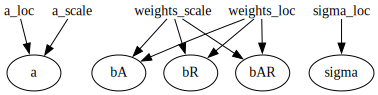

In [11]:
pyro.render_model(custom_guide, model_args=(is_cont_africa, ruggedness, log_gdb), render_params=True)

In [12]:
%%time
pyro.clear_param_store()

# These should be reset each training loop.
auto_guide = pyro.infer.autoguide.AutoNormal(model)
adam = pyro.optim.Adam({"lr": 0.02})  # Consider decreasing learning rate.
elbo = pyro.infer.Trace_ELBO()
svi = pyro.infer.SVI(model, auto_guide, adam, elbo)

CPU times: user 1.21 ms, sys: 939 µs, total: 2.15 ms
Wall time: 1.92 ms


Elbo loss: 694.9404826164246
Elbo loss: 524.3822077512741
Elbo loss: 475.668145775795
Elbo loss: 399.9908837676048
Elbo loss: 315.23277485370636
Elbo loss: 254.76769989728928
Elbo loss: 248.2370549440384
Elbo loss: 248.4266900420189
Elbo loss: 248.46450012922287
Elbo loss: 257.41463351249695


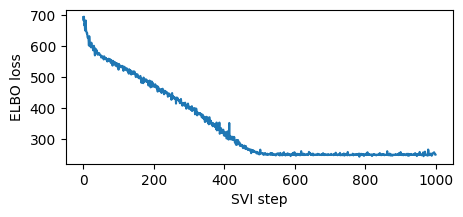

In [13]:

losses = []
for step in range(1000 if not smoke_test else 2):  # Consider running for more steps.
    loss = svi.step(is_cont_africa, ruggedness, log_gdb)
    losses.append(loss)
    if step % 100 == 0:
        logging.info("Elbo loss: {}".format(loss))

plt.figure(figsize=(5, 2))
plt.plot(losses)
plt.xlabel("SVI step")
plt.ylabel("ELBO loss");

In [14]:
for name, value in pyro.get_param_store().items():
    print(name, pyro.param(name).data.cpu().numpy())

AutoNormal.locs.a 9.173145
AutoNormal.scales.a 0.07036687
AutoNormal.locs.bA -1.8474661
AutoNormal.scales.bA 0.14070092
AutoNormal.locs.bR -0.19032115
AutoNormal.scales.bR 0.044044245
AutoNormal.locs.bAR 0.35599774
AutoNormal.scales.bAR 0.07937442
AutoNormal.locs.sigma -2.2058628
AutoNormal.scales.sigma 0.06052672


In [15]:
with pyro.plate("samples", 800, dim=-1):
    samples = auto_guide(is_cont_africa, ruggedness)



In [16]:
gamma_within_africa = samples['bR'] + samples["bAR"]
gamma_outside_africa = samples['bR']

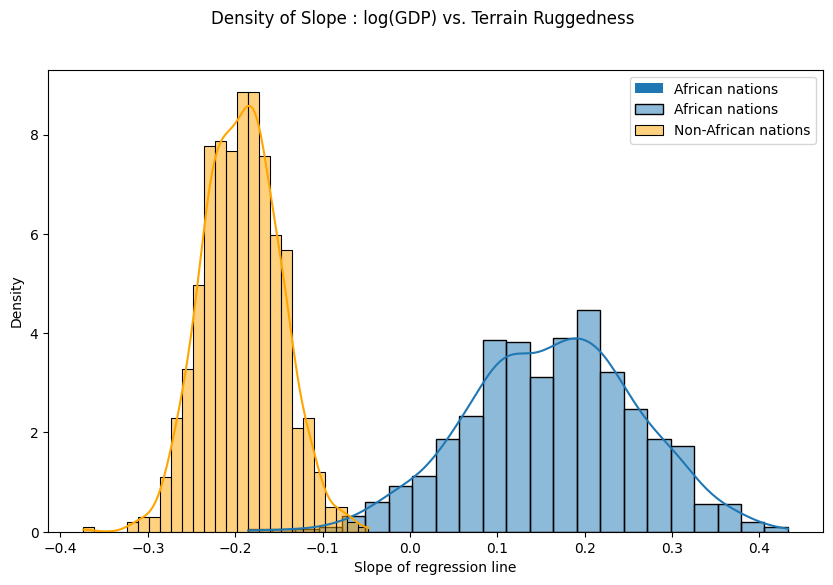

In [17]:
fig = plt.figure(figsize=(10, 6))
sns.histplot(gamma_within_africa.detach().cpu().numpy(), kde=True, stat="density", label="African nations")
sns.histplot(gamma_outside_africa.detach().cpu().numpy(), kde=True, stat="density", label="Non-African nations", color="orange")
fig.suptitle("Density of Slope : log(GDP) vs. Terrain Ruggedness");
plt.xlabel("Slope of regression line")
plt.legend()
plt.show()

In [18]:
# parametrized distribution in pyro --> guide (variational distribution), approximation to the posterior

# Our goal will be to find the (not necessarily unique) probability distribution in that space that is the best possible approximation to the posterior distribution

# simple example
def model(data):
    # define the hyperparameters that control the Beta prior
    alpha0 = torch.tensor(10.0)
    beta0 = torch.tensor(10.0)
    # sample f from the Beta prior
    f = pyro.sample("latent_fairness", dist.Beta(alpha0, beta0))
    # loop over the observed data
    for i in range(len(data)):
        # observe datapoint i using the Bernoulli
        # likelihood Bernoulli(f)
        pyro.sample("obs_{}".format(i), dist.Bernoulli(f), obs=data[i])
    '''with pyro.plate("data_plate", len(data)):
        pyro.sample("observed_data", dist.Bernoulli(f), obs=data)'''

#guide for latent variables
def guide(data):
    alpha_q = pyro.param("alpha_q", torch.tensor(15.0), constraint=constraints.positive)
    beta_q = pyro.param("beta_q", torch.tensor(15.0), constraint=constraints.positive)

    pyro.sample("latent_fairness", dist.Beta(alpha_q, beta_q))


In [19]:
data = []
for _ in range(6):
    data.append(torch.tensor(1.0))
for _ in range(4):
    data.append(torch.tensor(0.0))

data

[tensor(1.),
 tensor(1.),
 tensor(1.),
 tensor(1.),
 tensor(1.),
 tensor(1.),
 tensor(0.),
 tensor(0.),
 tensor(0.),
 tensor(0.)]

In [20]:


smoke_test = ('CI' in os.environ)
n_steps = 2 if smoke_test else 2000
# setup the optimizer
adam_params = {"lr": 0.0005, "betas": (0.90, 0.999)}
optimizer = Adam(adam_params)

# setup the inference algorithm
svi = SVI(model, guide, optimizer, loss=Trace_ELBO())

# do gradient steps
for step in range(n_steps):
    svi.step(data)
    if step % 100 == 0:
        print('.', end='')


....................

In [21]:
import math
# grab the learned variational parameters

alpha_q = pyro.param("alpha_q").item()
beta_q = pyro.param("beta_q").item()

# here we use some facts about the Beta distribution
# compute the inferred mean of the coin's fairness
inferred_mean = alpha_q / (alpha_q + beta_q)
# compute inferred standard deviation
factor = beta_q / (alpha_q * (1.0 + alpha_q + beta_q))
inferred_std = inferred_mean * math.sqrt(factor)

print("\nBased on the data and our prior belief, the fairness " +
      "of the coin is %.3f +- %.3f" % (inferred_mean, inferred_std))


Based on the data and our prior belief, the fairness of the coin is 0.536 +- 0.090


In [2]:
# set the concentration parameter alpha
alpha = torch.tensor([1., 1.])

# sample from the Dirichlet distribution to create a 3x3 matrix
dirichlet_matrix = dist.Dirichlet(alpha).sample(torch.Size([2]))


# print the matrix
print(dirichlet_matrix)


tensor([[0.2139, 0.7861],
        [0.1493, 0.8507]])


# Latent Dirichlet Algorithm

In [3]:
from fear_gen import extract_correct_csv
os.chdir("fear_gen")
valid_sub = extract_correct_csv.extract_only_valid_subject()
valid_sub

[1,
 2,
 4,
 5,
 6,
 7,
 13,
 15,
 16,
 17,
 21,
 22,
 23,
 26,
 27,
 28,
 31,
 32,
 33,
 41,
 43,
 44,
 45,
 46,
 47,
 48,
 50,
 51,
 52,
 54]

In [4]:
# read dataset
os.chdir('..')
df = pd.read_csv('fear_gen/data/newLookAtMe/newLookAtMe02.csv')
df_rational = df[['morphing level', 'shock']]
df_rational['shock'] = df_rational['shock'].astype(int)
df_rational['morphing level'] = [int(d==6) for d in df_rational['morphing level']]

/var/folders/hn/nq1_cby521sbf58lnj9qj9mw0000gn/T/ipykernel_14953/76822954.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_rational['shock'] = df_rational['shock'].astype(int)
/var/folders/hn/nq1_cby521sbf58lnj9qj9mw0000gn/T/ipykernel_14953/76822954.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_rational['morphing level'] = [int(d==6) for d in df_rational['morphing level']]


In [5]:
# categorical/multinomial distribution
# LDA
prior_counts = torch.ones((2,2))
def model(data):
    prior = pyro.sample("prior", dist.Dirichlet(prior_counts))
    total_counts = int(data.sum())
    pyro.sample("posterior", dist.Multinomial(total_counts, prior), obs=data)

In [6]:
data_np = df_rational.to_numpy()
data_all = data_np[16:]
learning_data = data_np[16:48]
learning_data

array([[1, 1],
       [0, 0],
       [0, 0],
       [1, 1],
       [0, 0],
       [1, 1],
       [1, 1],
       [0, 0],
       [1, 0],
       [1, 1],
       [0, 0],
       [0, 0],
       [0, 0],
       [0, 0],
       [1, 1],
       [1, 0],
       [0, 0],
       [1, 1],
       [1, 1],
       [0, 0],
       [1, 0],
       [0, 0],
       [1, 1],
       [0, 0],
       [1, 0],
       [0, 0],
       [1, 1],
       [0, 0],
       [1, 1],
       [0, 0],
       [1, 1],
       [0, 0]])

In [7]:
data = torch.tensor(data_all)
N = data.shape[0]
dict_ = {'[0 0]':0, '[0 1]': 0, '[1 0]':0, '[1 1]':0}
for x in data_all:
    dict_[str(x)] += 1


In [8]:
counter = torch.zeros((N,4))

for i in range(len(data_all)):
    dict_ = {'[0 0]':0, '[0 1]': 0, '[1 0]':0, '[1 1]':0}
    tmp_data = data_all[:i+1]
    for x in tmp_data:
        dict_[str(x)] += 1
    values = np.array(list(dict_.values()))
    counter[i] = torch.tensor(values)

In [9]:
counter = counter.reshape((len(data_all), 2, 2))
counter

tensor([[[ 0.,  0.],
         [ 0.,  1.]],

        [[ 1.,  0.],
         [ 0.,  1.]],

        [[ 2.,  0.],
         [ 0.,  1.]],

        [[ 2.,  0.],
         [ 0.,  2.]],

        [[ 3.,  0.],
         [ 0.,  2.]],

        [[ 3.,  0.],
         [ 0.,  3.]],

        [[ 3.,  0.],
         [ 0.,  4.]],

        [[ 4.,  0.],
         [ 0.,  4.]],

        [[ 4.,  0.],
         [ 1.,  4.]],

        [[ 4.,  0.],
         [ 1.,  5.]],

        [[ 5.,  0.],
         [ 1.,  5.]],

        [[ 6.,  0.],
         [ 1.,  5.]],

        [[ 7.,  0.],
         [ 1.,  5.]],

        [[ 8.,  0.],
         [ 1.,  5.]],

        [[ 8.,  0.],
         [ 1.,  6.]],

        [[ 8.,  0.],
         [ 2.,  6.]],

        [[ 9.,  0.],
         [ 2.,  6.]],

        [[ 9.,  0.],
         [ 2.,  7.]],

        [[ 9.,  0.],
         [ 2.,  8.]],

        [[10.,  0.],
         [ 2.,  8.]],

        [[10.,  0.],
         [ 3.,  8.]],

        [[11.,  0.],
         [ 3.,  8.]],

        [[11.,  0.],
         [ 

In [10]:
nuts_kernel = NUTS(model)
num_samples, warmup_steps = (300, 200)
mcmc = MCMC(nuts_kernel, num_samples=num_samples, warmup_steps=warmup_steps, disable_progbar=True)
all_means = []
for i in range(len(counter)):
    mcmc.run(counter[i])
    hmc_samples = {k: v.detach().cpu().numpy()
                for k, v in mcmc.get_samples().items()}
    means = hmc_samples['prior'].mean(axis=0)
    stds = hmc_samples['prior'].std(axis=0)
    print('observation: ', data_all[i])
    print('probabilities: ', means)
    all_means.append(means)


observation:  [1 1]
probabilities:  [[0.51642144 0.48357844]
 [0.32457966 0.6754207 ]]
observation:  [0 0]
probabilities:  [[0.6729735  0.32702678]
 [0.32506058 0.67493945]]
observation:  [0 0]
probabilities:  [[0.7431099  0.25689012]
 [0.322599   0.67740107]]
observation:  [1 1]
probabilities:  [[0.7372084  0.26279148]
 [0.26225013 0.7377501 ]]
observation:  [0 0]
probabilities:  [[0.7999909  0.20000905]
 [0.2730125  0.7269871 ]]
observation:  [1 1]
probabilities:  [[0.7859121  0.2140879 ]
 [0.20459197 0.79540795]]
observation:  [1 1]
probabilities:  [[0.8001468  0.19985338]
 [0.16650237 0.83349764]]
observation:  [0 0]
probabilities:  [[0.8398203  0.16017935]
 [0.16020943 0.83979064]]
observation:  [1 0]
probabilities:  [[0.83040905 0.16959079]
 [0.2726035  0.7273967 ]]
observation:  [1 1]
probabilities:  [[0.836752   0.16324833]
 [0.28405067 0.7159494 ]]
observation:  [0 0]
probabilities:  [[0.8572988  0.14270076]
 [0.26824936 0.7317506 ]]
observation:  [0 0]
probabilities:  [[0.883

KeyboardInterrupt: 

In [ ]:
X = np.arange(16, 16+len(all_means))
X_training = np.arange(16, 48)
all_means = np.array(all_means)
y = all_means[:, 1, 1]
y_training = all_means[:32, 1, 1]

In [ ]:
list_ = []
for index, i in enumerate(data_all):
    if np.equal(i, np.array([1,1])).all():
        list_.append(np.array([X[index], y[index]]))
x_points, y_points = np.array(list_)[:,0], np.array(list_)[:,1]


In [ ]:
fig = plt.figure(figsize=(12,8))

plt.plot(X, y, label='P(C=1|S=1)', color = 'black', alpha=0.8)
plt.scatter(x_points, y_points, marker='*', color='red', linewidths=2, label='CS+ and shock')
plt.ylabel('p')
plt.xlabel('Trial')
plt.legend()
plt.axvline(x=48, linestyle='--')
plt.axvline(x=16, linestyle='--')
plt.show()

In [ ]:
array_csplus = []
array_csminus = []
for index, data in enumerate(data_all):
    if data[0] == 1:
        array_csplus.append([X[index], all_means[index,1,1]])
    else:
        array_csminus.append([X[index], all_means[index,0,1]])

csplus_learning = []
csminus_learning = []
total_simulated = []
for index_train, data_train in enumerate(learning_data):
    if data_train[0] == 1:
        csplus_learning.append([X_training[index_train], all_means[index_train,1,1]])
        total_simulated.append(all_means[index_train,1,1])
    else:
        csminus_learning.append([X_training[index_train], all_means[index_train,0,1]])
        total_simulated.append(all_means[index_train,0,1])

total_simulated = np.array(total_simulated)
array_csplus = np.array(array_csplus)
array_csminus = np.array(array_csminus)
csplus_learning = np.array(csplus_learning)
csminus_learning = np.array(csminus_learning)

In [ ]:
len(total_simulated)

In [ ]:
print(array_csminus[:,0], csminus_learning[:,0])

In [ ]:
df_ = df[['shock', 'rating', 'morphing level']]
df_['shock'] = df_['shock'].astype(int)
df_['morphing level'] = [int(d == 6) for d in df_['morphing level']]
df_['rating'] = df_['rating'].replace([1, 2, 3, 4, 5], [0.2, 0.4, 0.6, 0.8, 1])

In [ ]:
df_new=df_[16:]
df_learning = df_[16:48]
df_learning

In [ ]:
df_learning

In [ ]:
y_plus_real = df_new.loc[df_new['morphing level']==1].rating.values
x_plus_real = np.array(df_new.loc[df_new['morphing level']==1].index)
y_minus_real = df_new.loc[df_new['morphing level']==0].rating.values
x_minus_real = np.array(df_new.loc[df_new['morphing level']==0].index)
y_real=df_new.rating.values

y_plus_train = df_learning.loc[df_learning['morphing level']==1].rating.values
x_plus_train = np.array(df_learning.loc[df_learning['morphing level']==1].index)
y_minus_train = df_learning.loc[df_learning['morphing level']==0].rating.values
x_minus_train = np.array(df_learning.loc[df_learning['morphing level']==0].index)
y_train=df_learning.rating.values

In [ ]:
fig = plt.figure(figsize=(13,6))
plt.scatter(x_plus_real, y_plus_real, color='blue', label='cs+ real')
plt.scatter(x_minus_real, y_minus_real, color='red', label='non cs+ real')
plt.scatter(array_csplus[:,0], array_csplus[:,1], color='darkblue', label='cs+ simulated')
plt.scatter(array_csminus[:,0], array_csminus[:,1], color='darkred', label='cs- simulated')
plt.legend(loc='right')
plt.axvline(x=16, linestyle='--', color='green')
plt.axvline(x=48, linestyle='--', color='green')
plt.xlabel('Trial')
plt.ylabel('P(condition | visual stimulus)')
plt.show()

In [ ]:
print(len(y_minus_train), len(csminus_learning[:,1]))

In [ ]:
fig2 = plt.figure(figsize=(13,6))
plt.scatter(x_plus_train, y_plus_train, color='blue', label='cs+ real')
plt.scatter(x_minus_train, y_minus_train, color='red', label='non cs+ real')
plt.scatter(csplus_learning[:,0], csplus_learning[:,1], color='darkblue', label='cs+ simulated')
plt.scatter(csminus_learning[:,0], csminus_learning[:,1], color='darkred', label='cs- simulated')
plt.legend(loc='right')
plt.axvline(x=16, linestyle='--', color='green')
plt.axvline(x=48, linestyle='--', color='green')
plt.xlabel('Trial')
plt.ylabel('P(condition | visual stimulus)')
plt.show()
plt.show()

In [ ]:
y_plus_train

In [ ]:
csplus_learning[:,1]

In [ ]:
np.corrcoef(y_plus_train, csplus_learning[:,1])

In [ ]:
np.corrcoef(y_minus_train, csminus_learning[:,1])

In [ ]:
np.corrcoef(y_train,total_simulated)

In [ ]:
total_simulated